Copyright 2022 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This colab accompanies the paper 'Role of Human-AI Interaction in Selective Prediction' in AAAI 2022 by Bondi et al.

In [ ]:
from typing import Tuple, Sequence
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import tempfile

from HAI_selective_prediction import utils
from HAI_selective_prediction import conformity_analysis

In [9]:
def load_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
  """Loads the human data.
  
  Returns:
  A tuple of (participant_df, imagewise_df), where:
    participant_df: Each row contains data averaged from a participant's
      responses to 5 images with the same metadata. That is, those 5 images had
      the same ground truth label, model prediction, messaging condition, and
      status of whether the model was correct or not. As the dataset presented
      to human participants was balanced across these conditions, there are 16
      rows per participant id, making a total of 80 images.
      Columns:
        participant_id: Which participant made the response (anonymised).
        accuracy: Participant accuracy over 5 images in the same category.
        preds: Whether the model predicted an animal was present.
        labels: Ground truth labels. 1 = animal present; 0 = no animal present.
        preds_msg: Whether a prediction message was shown with the image.
        defer_msg: Whether a deferral message was shown with the image.
        model_correct: Whether the model correctly classified this image.
    imagewise_df: Each row is a unique image that was evaluated by participants.
      Columns:
        image_name: Unique image identifier.
        label: Ground truth labels. 1 = animal present; 0 = no animal present.
        model_score: Logits output from the model (threshold=0.1931999921798706).
        model_prediction: Whether model predicted an animal present.
        human_likert: Likert ratings from human participants.
        human_correct: Whether human participants correctly classified the image.
        human_accuracy: Average of human_correct scores across all ratings.
        condition_form_X: Which of the four conditions (NM, DO, PO, BM) the
          image was used for in a given randomisation.
        human_ratings_form_X: Human likert ratings when image presented in a
          given randomisation.
  """
  f = tempfile.NamedTemporaryFile()
  !gsutil cp "gs://dm-hai-selective-prediction/participant_df.pd" {f.name}
  with open(f.name, 'rb') as file:
    participant_df = pd.read_parquet(file)

  f = tempfile.NamedTemporaryFile()
  !gsutil cp "gs://dm-hai-selective-prediction/imagewise_df.pd" {f.name}
  with open(f.name, 'rb') as file:
    imagewise_df = pd.read_parquet(file)     

  return (participant_df, imagewise_df)


In [10]:
participant_df, imagewise_df = load_data()
participant_df.head(10)

Copying gs://dm-hai-selective-prediction/participant_df.pd...
/ [1 files][  7.9 KiB/  7.9 KiB]                                                
Operation completed over 1 objects/7.9 KiB.                                      
Copying gs://dm-hai-selective-prediction/imagewise_df.pd...
/ [1 files][ 29.6 KiB/ 29.6 KiB]                                                
Operation completed over 1 objects/29.6 KiB.                                     


,participant_id,accuracy,preds,labels,preds_msg,defer_msg,model_correct
0,2,0.6,0,0,0,0,1
1,2,0.6,0,0,0,1,1
2,2,0.8,0,0,1,0,1
3,2,1.0,0,0,1,1,1
4,2,0.0,0,1,0,0,0
5,2,0.6,0,1,0,1,0
6,2,0.4,0,1,1,0,0
7,2,0.8,0,1,1,1,0
8,2,0.4,1,0,0,0,0
9,2,0.8,1,0,0,1,0


In [11]:
imagewise_df.head(10)

,image_name,label,model_score,model_prediction,human_likert,human_correct,human_accuracy,condition_form_0,condition_form_1,condition_form_2,condition_form_3,human_ratings_form_0,human_ratings_form_1,human_ratings_form_2,human_ratings_form_3
0,S1/E06/E06_R3/S1_E06_R3_PICT0045,1,0.100182,0,"[5, 1, 3, 3, 4, 5, 5, 1, 5, 4, 1, 4, 1, 4, 1, ...","[1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, ...",26.767677,DO,NM,NM,PO,"[5.0, 1.0, 3.0, 3.0, 4.0, 5.0, 5.0, 1.0, 5.0, ...","[1.0, 1.0, 2.0, 5.0, 1.0, 2.0, 1.0, 2.0, 5.0, ...","[1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 4.0, 1.0, 2.0, ...","[2.0, 3.0, 2.0, 2.0, 2.0, 5.0, 2.0, 1.0, 2.0, ..."
1,S1/G02/G02_R4/S1_G02_R4_PICT0088,0,0.116808,0,"[1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",96.969697,NM,PO,PO,NM,"[1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, ...","[1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, ..."
2,S1/F09/F09_R2/S1_F09_R2_PICT1369,0,0.330209,1,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2, 5, 5, 5, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",1.515152,NM,PO,NM,PO,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, ...","[5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
3,S1/G10/G10_R1/S1_G10_R1_PICT0367,0,0.115413,0,"[5, 4, 4, 1, 4, 5, 5, 1, 5, 4, 1, 4, 5, 2, 5, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...",22.727273,DO,PO,PO,PO,"[5.0, 4.0, 4.0, 1.0, 4.0, 5.0, 5.0, 1.0, 5.0, ...","[5.0, 1.0, 4.0, 4.0, 5.0, 1.0, 4.0, 4.0, 1.0, ...","[2.0, 3.0, 4.0, 3.0, 2.0, 5.0, 5.0, 5.0, 4.0, ...","[5.0, 4.0, 5.0, 1.0, 5.0, 4.0, 5.0, 5.0, 2.0, ..."
4,S1/F02/F02_R4/S1_F02_R4_PICT1790,1,0.268470,1,"[1, 1, 1, 1, 2, 1, 3, 1, 3, 2, 1, 2, 1, 1, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.525253,DO,BM,NM,DO,"[1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 3.0, 1.0, 3.0, ...","[1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, ...","[1.0, 1.0, 2.0, 5.0, 1.0, 1.0, 1.0, 1.0, 3.0, ...","[1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, ..."
5,S1/I02/I02_R1/S1_I02_R1_PICT1954,1,0.115198,0,"[1, 1, 5, 1, 5, 3, 3, 1, 3, 3, 1, 2, 3, 3, 1, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48.484848,PO,BM,DO,DO,"[1.0, 1.0, 5.0, 1.0, 5.0, 3.0, 3.0, 1.0, 3.0, ...","[5.0, 5.0, 2.0, 5.0, 5.0, 5.0, 1.0, 5.0, 1.0, ...","[2.0, 1.0, 3.0, 1.0, 1.0, 1.0, 5.0, 5.0, 3.0, ...","[3.0, 3.0, 5.0, 5.0, 3.0, 1.0, 5.0, 4.0, 5.0, ..."
6,S1/H01/H01_R1/S1_H01_R1_PICT2586,0,0.108003,0,"[1, 4, 1, 1, 1, 1, 2, 2, 1, 2, 1, 3, 1, 4, 2, ...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, ...",80.303030,DO,NM,NM,PO,"[1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, ...","[1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[1.0, 3.0, 5.0, 1.0, 2.0, 3.0, 3.0, 1.0, 1.0, ...","[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
7,S1/I07/I07_R1/S1_I07_R1_PICT1376,1,0.268022,1,"[5, 1, 4, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",46.464646,NM,PO,PO,NM,"[5.0, 1.0, 4.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, ...","[5.0, 1.0, 3.0, 1.0, 5.0, 4.0, 1.0, 4.0, 4.0, ...","[2.0, 2.0, 5.0, 3.0, 4.0, 4.0, 3.0, 1.0, 4.0, ...","[4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 4.0, 1.0, ..."
8,S1/H11/H11_R1/S1_H11_R1_PICT5454,0,0.105132,0,"[1, 1, 1, 2, 2, 1, 3, 1, 1, 2, 1, 1, 1, 3, 2, ...","[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, ...",85.353535,NM,PO,BM,DO,"[1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 3.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 5.0, 1.0, 2.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 3.0, 2.0, 1.0, 1.0, 4.0, 1.0, 1.0, ...","[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, ..."
9,S1/I08/I08_R1/S1_I08_R1_PICT0142,0,0.295539,1,"[3, 1, 2, 4, 2, 5, 3, 1, 3, 4, 1, 5, 2, 2, 1, ...","[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, ...",76.262626,BM,DO,PO,DO,"[3.0, 1.0, 2.0, 4.0, 2.0, 5.0, 3.0, 1.0, 3.0, ...","[1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0, ...","[2.0, 2.0, 3.0, 1.0, 3.0, 3.0, 1.0, 1.0, 3.0

In [ ]:
# Calculate accuracy per condition for plotting.
# NM means image was presented with no message.
accuracy_condition_nm = participant_df.query('preds_msg == 0 & defer_msg == 0').groupby(['participant_id']).mean()['accuracy'].to_numpy()
# DO means image was presented with deferral message only.
accuracy_condition_do = participant_df.query('preds_msg == 0 & defer_msg == 1').groupby(['participant_id']).mean()['accuracy'].to_numpy()
# PO means image was presented with prediction message only.
accuracy_condition_po = participant_df.query('preds_msg == 1 & defer_msg == 0').groupby(['participant_id']).mean()['accuracy'].to_numpy()
# BM means image was presented with both messages.
accuracy_condition_bm = participant_df.query('preds_msg == 1 & defer_msg == 1').groupby(['participant_id']).mean()['accuracy'].to_numpy()

fig1_data = [accuracy_condition_nm, accuracy_condition_do, accuracy_condition_po, accuracy_condition_bm]
fig1_means = [np.mean(condition_accuracy) for condition_accuracy in fig1_data]
fig1_errors = [utils.get_95confidence(condition_accuracy) for condition_accuracy in fig1_data]


In [ ]:
# Calculate accuracy per condition for plotting.
fig2_means = []
fig2_errors = []
fig2_data = []
for correctness in utils.CORRECTNESS_LABELS:
  accuracy_nm = participant_df.query(f'preds_msg == 0 & defer_msg == 0 & model_correct == {correctness}').groupby(['participant_id']).mean()['accuracy'].to_numpy()
  accuracy_do = participant_df.query(f'preds_msg == 0 & defer_msg == 1 & model_correct == {correctness}').groupby(['participant_id']).mean()['accuracy'].to_numpy()
  accuracy_po = participant_df.query(f'preds_msg == 1 & defer_msg == 0 & model_correct == {correctness}').groupby(['participant_id']).mean()['accuracy'].to_numpy()
  accuracy_bm = participant_df.query(f'preds_msg == 1 & defer_msg == 1 & model_correct == {correctness}').groupby(['participant_id']).mean()['accuracy'].to_numpy()

  accuracy_across_conditions = [accuracy_nm, accuracy_do, accuracy_po, accuracy_bm]
  accuracy_means = [np.mean(condition_accuracy) for condition_accuracy in accuracy_across_conditions]
  accuray_errors = [utils.get_95confidence(condition_accuracy) for condition_accuracy in accuracy_across_conditions]
  fig2_means.append(accuracy_means)
  fig2_errors.append(accuray_errors)
  fig2_data.append(accuracy_across_conditions)

In [ ]:
# Consider human accuracy on each image in specific conditions.
imagewise_accuracy = utils.compute_imagewise_accuracy(
    data=imagewise_df,
    conditions=['NM', 'DO'],
)

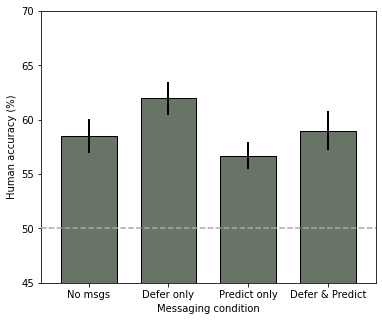

In [ ]:
# @title Figure 5: Plot human accuracy for the four conditions
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
condition_labels = ['No msgs', 'Defer only', 'Predict only', 'Defer & Predict']
fig.patch.set_facecolor('white')
utils.figure_5(
    means=fig1_means,
    errors=fig1_errors,
    labels=condition_labels,
    ax=ax,
    colours=utils.COLOURS,
)

Difference between low and high confidence conformity: t=2.54, p=0.014


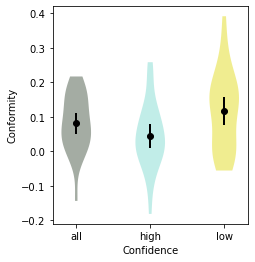

In [ ]:
# @title Figure 6: Rater conformity analysis

# Compute the conformity results under different confidence conditions.
overall = conformity_analysis.get_delta_agreement(
    conformity_analysis.ConfidenceLevel.ALL,
    imagewise_df,
)
high = conformity_analysis.get_delta_agreement(
    conformity_analysis.ConfidenceLevel.HIGH,
    imagewise_df,
)
low = conformity_analysis.get_delta_agreement(
    conformity_analysis.ConfidenceLevel.LOW,
    imagewise_df,
)

violin_colours = ['#687566', '#99E1D9', '#E7E247']

# Produce Figure 6 plus associated statistics.
utils.figure_6(
    all_conformity=overall,
    sure_conformity=high,
    unsure_conformity=low,
    colours=violin_colours,
    )

Difference : t=2.19, p=0.032


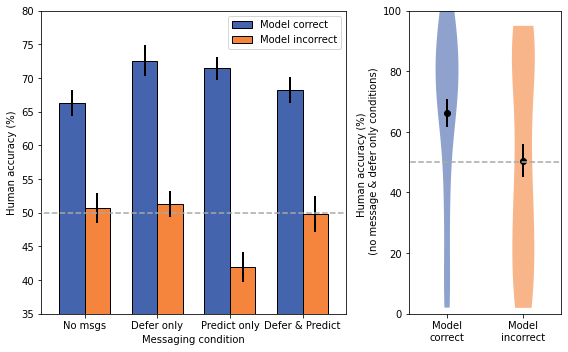

In [ ]:
# @title Figure 7: Investigation of accuracy split by model correctness

fig, ax = plt.subplots(1, 2,
                       figsize=(8, 5),
                       gridspec_kw={'width_ratios': [1, 0.5]})
utils.figure_7a(
    means=fig2_means,
    errors=fig2_errors,
    labels=condition_labels,
    ax=ax[0],
    colours=utils.COLOURS[1:],
)
utils.figure_7b(
    imagewise_accuracy['model_correct'],
    imagewise_accuracy['model_incorrect'],
    ax=ax[1],
    colours=utils.COLOURS,
)
fig.patch.set_facecolor('white')
fig.tight_layout()

In [ ]:
# Imagewise correlation between human likert ratings and model scores on the same images.
likert_per_image, model_score = utils.compute_human_and_model_scores(
    data=imagewise_df,
    conditions=['NM', 'DO'],
)
coeff, p = scipy.stats.pearsonr(likert_per_image, model_score)
print(f'Correlation coefficient: {coeff:.2f}, p={p:.3f}')

Correlation coefficient: 0.27, p=0.021
